In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane_snowflurry.utility.debug_utility import SnowflurryUtility, arbitrary_circuit, get_labels
from pennylane_snowflurry.transpiler.monarq_transpile import Transpiler
from pennylane_snowflurry.transpiler.transpiler_config import MonarqDefaultConfig
from pennylane_snowflurry.utility.noisy_device import NoisyDevice

In [241]:
num_qubits = 4

dev = NoisyDevice(shots=10000, noise=1)

def circuit(size : int):
    qml.Hadamard(0)
    for n in range(0, size - 1):
        qml.CNOT([n, n + 1])
    
    return qml.counts(wires=[i for i in range(size)])

In [242]:
def transpile_snowflurry(tape):
    snowflurryUtil = SnowflurryUtility(tape, 
                                       "https://manager.anyonlabs.com", 
                                       "stage", 
                                       "FjjIKjmDMoAMzSO4v2Bu62a+8vD39zib", 
                                       "calculqc")
    snowflurryUtil.transpile()
    return snowflurryUtil.to_pennylane()

def transpile_calculqc(tape, config):
    transpiler = Transpiler.get_transpiler(config)
    return transpiler(tape)[0][0]


In [ ]:
datas = {"optimized" : [],
         "unoptimized" : []}


qnode = qml.QNode(lambda: circuit(4), dev)
qnode()
sf_tape = transpile_snowflurry(qnode.tape)
cq_tape = transpile_calculqc(qnode.tape, MonarqDefaultConfig(useBenchmark=False))

sf_node = qml.QNode(lambda : arbitrary_circuit(sf_tape, qml.counts), dev)
cq_node = qml.QNode(lambda : arbitrary_circuit(cq_tape, qml.counts), dev)

sf_results = sf_node()[0]
cq_results = cq_node()[0][()]

x_labels = get_labels((2**4) - 1)
datas["unoptimized"] = [int(sf_results[key]) if key in sf_results else 0 for key in x_labels]
datas["optimized"] = [int(cq_results[key]) if key in cq_results else 0 for key in x_labels]

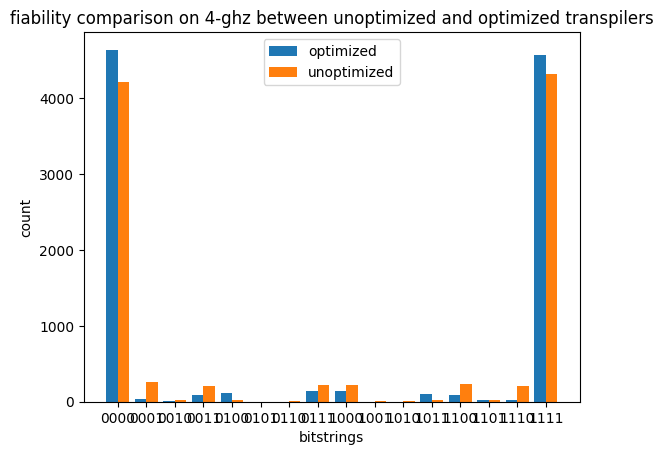

In [244]:
x_axis = np.arange(len(x_labels))

for i in range(len(datas.keys())):
    key = list(datas.keys())[i]
    plt.bar(x_axis - 0.2 + 0.4 * i , datas[key], 0.4, label = key)

plt.xticks(x_axis, x_labels)
plt.title("fiability comparison on 4-ghz between unoptimized and optimized transpilers")
plt.xlabel("bitstrings")
plt.ylabel("count")
plt.legend()
plt.show()
